In [1]:
!pip3 install robustness

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.2 MB/s eta 0:00:00-:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 91.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 107.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 133.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.

In [2]:
with open("/usr/local/lib/python3.10/dist-packages/robustness/imagenet_models/__init__.py") as rf:
    contents = rf.read()
    contents = contents.replace("from .vgg import *", "#")
    contents = contents.replace("from .alexnet import *", "#")
    contents = contents.replace("from .squeezenet import *", "#")
    with open("/usr/local/lib/python3.10/dist-packages/robustness/imagenet_models/__init__.py", "w") as wf:
        wf.write(contents)
with open("/usr/local/lib/python3.10/dist-packages/robustness/train.py") as rf:
    contents = rf.read()
    target_string = '''    for i, (inp, target) in iterator:
       # measure data loading time
        target = target.cuda(non_blocking=True)
        output, final_inp = model(inp, target=target, make_adv=adv,
                                  **attack_kwargs)
        loss = train_criterion(output, target)'''
    replace_string = '''    import random
    import copy
    for i, (inp, target) in iterator:
       # measure data loading time
        target = target.cuda(non_blocking=True)
        atk_kwargs = {}
        atk = random.randint(1, 3)
        if atk == 1:
            atk_kwargs = copy.deepcopy(attack_kwargs)
        output, final_inp = model(inp, target=target, make_adv=adv,
                                  **attack_kwargs)
        loss = train_criterion(output, target)'''
    contents = contents.replace(target_string, replace_string)
    with open("/usr/local/lib/python3.10/dist-packages/robustness/train.py", "w") as wf:
        wf.write(contents)

In [48]:
import torchvision
from robustness import model_utils, datasets, train, defaults
from robustness.datasets import CIFAR
import torch
import torch.nn as nn
#from r50cosine import R50Cosine

# We use cox (http://github.com/MadryLab/cox) to log, store and analyze
# results. Read more at https//cox.readthedocs.io.
def set_seeds(seed):
    torch.manual_seed(seed)
    import random
    random.seed(seed)
    import numpy as np
    np.random.seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
set_seeds(0)
from cox.utils import Parameters
import cox.store

# Hard-coded dataset, architecture, batch size, workers
ds = CIFAR('/path/to/cifar')
#ds = ImageNet('/path/to/imagenet')
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/cifar_linf_8.pt")
#m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="workspace/resnet50_linf_eps8.0.ckpt")
initials = torch.randn([2048, 10])
class CosineLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(data=initials.to(device), requires_grad=True)
        self.bias = nn.Parameter(data=torch.randn(self.out_features))
    def forward(self, x):
        #print(torch.norm(x, dim=1))
        x = x / torch.norm(x, dim=1, keepdim=True)
        params = self.weight / torch.norm(self.params, dim=0)
        #concatenated = torch.stack([self.similarity(torch.stack([x[n] for m in range(self.out_features)], dim=1), self.params) for n in torch.arange(x.shape[0])], dim=0)
        #return concatenated
        return torch.matmul(x, params)
#print(m)
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=8)

=> loading checkpoint '/workspace/cifar_linf_8.pt'
=> loaded checkpoint '/workspace/cifar_linf_8.pt' (epoch 153)
==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
!pip3 install torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-server 2.25.0 requires requests>=2.31, but you have requests 2.25.1 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip ins

In [26]:
m

AttackerModel(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, mo

In [5]:
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/cifar_linf_8.pt")
import torchattacks
import torch.nn.functional as F
device = torch.device('cuda')
atk = torchattacks.PGD(nn.Sequential(m.normalizer, m.model).to(device))
mean_output_change = 0.0
mean_sign_change = 0
batch_count = 0
for i, data in enumerate(val_loader, 0):
    test_tensor = data[0].to(device)
    model = nn.Sequential(m.normalizer, m.model).to(device)
    model[1].linear = nn.Identity()
    model.eval()
    output = model(test_tensor).detach()
    model.train()
    adv_tensor = atk(test_tensor, data[1].to(device))
    model = nn.Sequential(m.normalizer, m.model).to(device)
    model[1].linear = nn.Identity()
    #print(adv_tensor.shape)
    model.eval()
    adv_output = model(adv_tensor).detach()
    model.train()
    #print(adv_output.shape)
    mean_output_change += torch.sum(F.relu(adv_output - output)).detach() # each feature changed by 0.0052
    mean_sign_change += (torch.sign(output) != torch.sign(adv_output)).detach().sum().item() # 9298 / (128 * 2048) features changed signs
    batch_count += 1
    if batch_count % 20 == 0:
        print(f"{batch_count} batches processed.")
    #break
print(mean_output_change / 10000 / 2048, mean_sign_change / 10000)

=> loading checkpoint '/workspace/cifar_linf_8.pt'
=> loaded checkpoint '/workspace/cifar_linf_8.pt' (epoch 153)
20 batches processed.
40 batches processed.
60 batches processed.
tensor(0.0132, device='cuda:0') 78.1142


In [6]:
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/resnet50_extra_pgd5_1epoch.pt")
import torchattacks
import torch.nn.functional as F
device = torch.device('cuda')
atk = torchattacks.PGD(nn.Sequential(m.normalizer, m.model).to(device))
mean_output_change = 0.0
mean_sign_change = 0
batch_count = 0
for i, data in enumerate(val_loader, 0):
    test_tensor = data[0].to(device)
    model = nn.Sequential(m.normalizer, m.model).to(device)
    model[1].linear = nn.Identity()
    model.eval()
    output = model(test_tensor).detach()
    model.train()
    adv_tensor = atk(test_tensor, data[1].to(device))
    model = nn.Sequential(m.normalizer, m.model).to(device)
    model[1].linear = nn.Identity()
    #print(adv_tensor.shape)
    model.eval()
    adv_output = model(adv_tensor).detach()
    model.train()
    #print(adv_output.shape)
    mean_output_change += torch.sum(F.relu(adv_output - output)).detach() # each feature changed by 0.0052
    mean_sign_change += (torch.sign(output) != torch.sign(adv_output)).detach().sum().item() # 9298 / (128 * 2048) features changed signs
    batch_count += 1
    if batch_count % 20 == 0:
        print(f"{batch_count} batches processed.")
    #break
print(mean_output_change / 10000 / 2048, mean_sign_change / 10000)

=> loading checkpoint '/workspace/resnet50_extra_pgd5_1epoch.pt'
=> loaded checkpoint '/workspace/resnet50_extra_pgd5_1epoch.pt' (epoch 1)
20 batches processed.
40 batches processed.
60 batches processed.
tensor(0.0126, device='cuda:0') 79.4403


In [ ]:
!pip3 install 

In [23]:
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/cifar_linf_8.pt")
import torchattacks
import numpy as np
import torch.nn.functional as F
device = torch.device('cuda')
atk = torchattacks.PGD(nn.Sequential(m.normalizer, m.model).to(device))
mean_output_change = 0.0
distrib = []
mean_sign_change = 0
batch_count = 0
for i, data in enumerate(val_loader, 0):
    test_tensor = data[0].to(device)
    model = nn.Sequential(m.normalizer, m.model).to(device)
    model[1].linear = nn.Identity()
    model.eval()
    output = model(test_tensor).detach()
    model.train()
    adv_tensor = atk(test_tensor, data[1].to(device))
    model = nn.Sequential(m.normalizer, m.model).to(device)
    model[1].linear = nn.Identity()
    #print(adv_tensor.shape)
    model.eval()
    adv_output = model(adv_tensor).detach()
    model.train()
    #print(adv_output.shape)
    #mean_output_change += torch.sum(torch.abs((adv_output - output) / output)).detach() # each feature changed by 0.0052
    pct_change = (torch.abs((adv_output - output) / output).detach().cpu().detach())
    for item in pct_change:
        distrib.append(np.array(item))
    #distrib.append(pct_change)
    mean_sign_change += (torch.sign(output) != torch.sign(adv_output)).detach().sum().item() # 9298 / (128 * 2048) features changed signs
    batch_count += 1
    if batch_count % 20 == 0:
        print(f"{batch_count} batches processed.")
    #break
print(mean_output_change / 10000 / 2048, mean_sign_change / 10000)

=> loading checkpoint '/workspace/cifar_linf_8.pt'
=> loaded checkpoint '/workspace/cifar_linf_8.pt' (epoch 153)
20 batches processed.
40 batches processed.
60 batches processed.
0.0 78.1002


In [53]:
#m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/cifar_linf_8.pt")
import torchattacks
import numpy as np
import torch.nn.functional as F
def analyze(m):
    device = torch.device('cuda')
    atk = torchattacks.PGD(nn.Sequential(m.normalizer, m.model).to(device))
    mean_output_change = 0.0
    distrib = []
    mean_sign_change = 0
    batch_count = 0
    for i, data in enumerate(val_loader, 0):
        test_tensor = data[0].to(device)
        model = nn.Sequential(m.normalizer, m.model).to(device)
        model[1].linear = nn.Identity()
        model.eval()
        output = model(test_tensor).detach()
        model.train()
        adv_tensor = atk(test_tensor, data[1].to(device))
        model = nn.Sequential(m.normalizer, m.model).to(device)
        model[1].linear = nn.Identity()
        #print(adv_tensor.shape)
        model.eval()
        adv_output = model(adv_tensor).detach()
        model.train()
        #print(adv_output.shape)
        #mean_output_change += torch.sum(torch.abs((adv_output - output) / output)).detach() # each feature changed by 0.0052
        pct_change = (torch.abs((adv_output - output) / output).cpu().detach())
        for item in pct_change:
            distrib.append(np.array(item))
        #distrib.append(pct_change)
        #mean_sign_change += (torch.sign(output) != torch.sign(adv_output)).detach().sum().item() # 9298 / (128 * 2048) features changed signs
        batch_count += 1
        if batch_count % 20 == 0:
            print(f"{batch_count} batches processed.")
    distrib = np.array(distrib).flatten()
    return distrib
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/cifar_linf_8.pt")
baseline = analyze(m)
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/resnet50_extra_pgd5_1epoch.pt")
pgd5 = analyze(m)
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/resnet50_extra_pgd40_1epoch.pt")
pgd40 = analyze(m)

=> loading checkpoint '/workspace/cifar_linf_8.pt'
=> loaded checkpoint '/workspace/cifar_linf_8.pt' (epoch 153)
20 batches processed.
40 batches processed.
60 batches processed.
=> loading checkpoint '/workspace/resnet50_extra_pgd5_1epoch.pt'
=> loaded checkpoint '/workspace/resnet50_extra_pgd5_1epoch.pt' (epoch 1)
20 batches processed.
40 batches processed.
60 batches processed.
=> loading checkpoint '/workspace/resnet50_extra_pgd40_1epoch.pt'
=> loaded checkpoint '/workspace/resnet50_extra_pgd40_1epoch.pt' (epoch 1)
20 batches processed.
40 batches processed.
60 batches processed.


In [58]:
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/resnet50_extra_pgd1_1epoch.pt")
pgd1 = analyze(m)
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path="/workspace/resnet50_extra_natural_1epoch.pt")
natural = analyze(m)

=> loading checkpoint '/workspace/resnet50_extra_pgd1_1epoch.pt'
=> loaded checkpoint '/workspace/resnet50_extra_pgd1_1epoch.pt' (epoch 1)
20 batches processed.
40 batches processed.
60 batches processed.
=> loading checkpoint '/workspace/resnet50_extra_natural_1epoch.pt'
=> loaded checkpoint '/workspace/resnet50_extra_natural_1epoch.pt' (epoch 1)
20 batches processed.
40 batches processed.
60 batches processed.


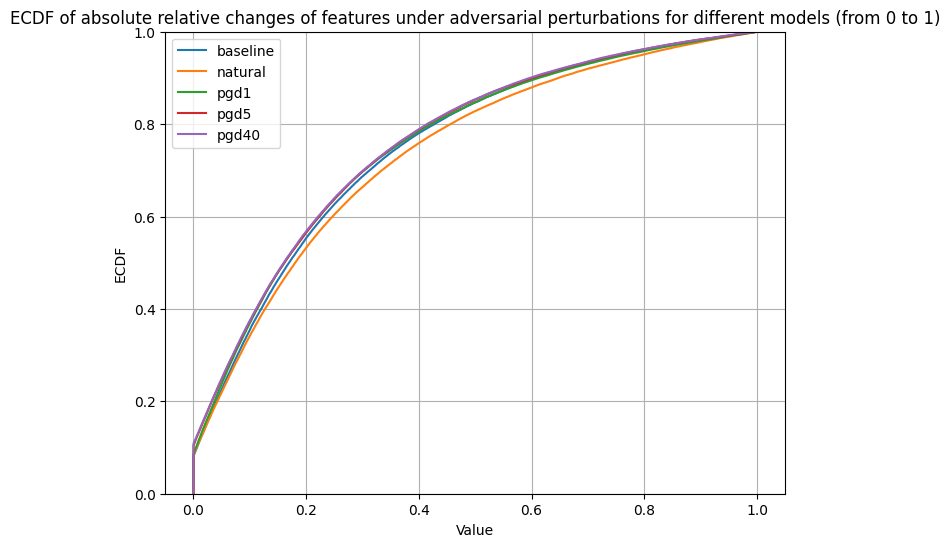

In [89]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.ecdfplot(np.random.choice(baseline[baseline < 1], 100000), label="baseline")
sns.ecdfplot(np.random.choice(natural[natural < 1], 100000), label="natural")
sns.ecdfplot(np.random.choice(pgd1[pgd1 < 1], 100000), label="pgd1")
sns.ecdfplot(np.random.choice(pgd5[pgd5 < 1], 100000), label="pgd5")
sns.ecdfplot(np.random.choice(pgd40[pgd40 < 1], 100000), label="pgd40")
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.title('ECDF of absolute relative changes of features under adversarial perturbations for different models (from 0 to 1)')
plt.grid(True)
plt.legend()
plt.savefig("fig1.png")
plt.show()

In [66]:
plt.savefig("fig1.png")

<Figure size 640x480 with 0 Axes>

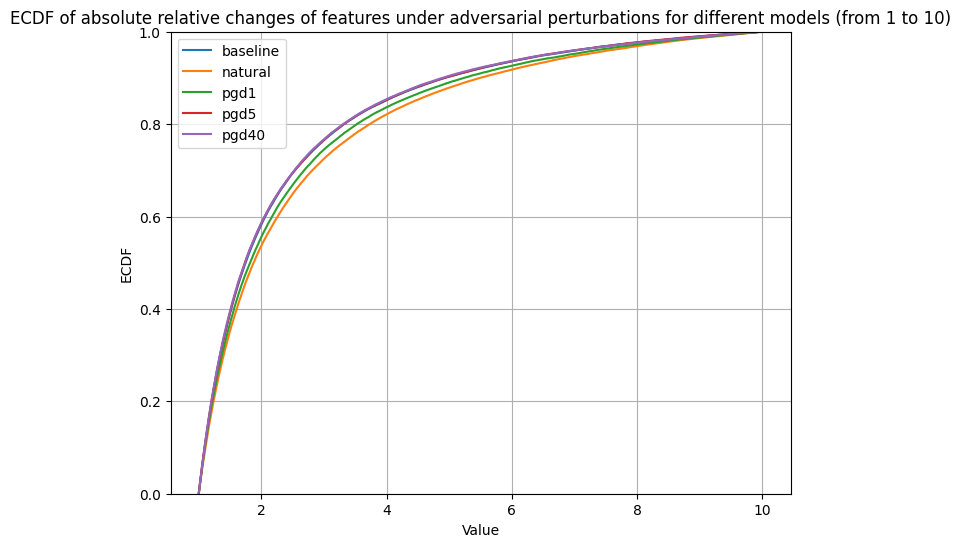

In [88]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.ecdfplot(np.random.choice(baseline[(baseline > 1) & (baseline < 10)], 100000), label="baseline")
sns.ecdfplot(np.random.choice(natural[(natural > 1) & (natural < 10)], 100000), label="natural")
sns.ecdfplot(np.random.choice(pgd1[(pgd1 > 1) & (pgd1 < 10)], 100000), label="pgd1")
sns.ecdfplot(np.random.choice(pgd5[(pgd5 > 1) & (pgd5 < 10)], 100000), label="pgd5")
sns.ecdfplot(np.random.choice(pgd40[(pgd40 > 1) & (pgd40 < 10)], 100000), label="pgd40")
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.title('ECDF of absolute relative changes of features under adversarial perturbations for different models (from 1 to 10)')
plt.grid(True)
plt.legend()
plt.savefig("fig2.png")
plt.show()

In [69]:
plt.savefig("fig2.png")

<Figure size 640x480 with 0 Axes>

In [87]:
print(np.median(np.nan_to_num(pgd40.astype(np.float64), 0, posinf=0, neginf=0)))
print(np.median(np.nan_to_num(pgd5.astype(np.float64), 0, posinf=0, neginf=0)))
print(np.median(np.nan_to_num(pgd1.astype(np.float64), 0, posinf=0, neginf=0)))
print(np.median(np.nan_to_num(natural.astype(np.float64), 0, posinf=0, neginf=0)))
print(np.median(np.nan_to_num(baseline.astype(np.float64), 0, posinf=0, neginf=0)))

0.19213353842496872
0.19280950725078583
0.1919577792286873
0.22018757462501526
0.2124207243323326


In [86]:
print(np.mean(np.nan_to_num(pgd40.astype(np.float64), 0, posinf=0, neginf=0)))
print(np.mean(np.nan_to_num(pgd5.astype(np.float64), 0, posinf=0, neginf=0)))
print(np.mean(np.nan_to_num(pgd1.astype(np.float64), 0, posinf=0, neginf=0)))
print(np.mean(np.nan_to_num(natural.astype(np.float64), 0, posinf=0, neginf=0)))
print(np.mean(np.nan_to_num(baseline.astype(np.float64), 0, posinf=0, neginf=0)))

1.3157690242728286
1.183300377104654
2.1802075221483306
1.895904078686134
6.834889946934826e+36


In [81]:
np.median(np.nan_to_num(pgd5, 0, posinf=0, neginf=0))

0.1928095

In [76]:
np.max(np.nan_to_num(baseline, 0, posinf=0, neginf=0))

3.4028235e+38